In [224]:
 import networkx as nx
import matplotlib.pyplot as plt

In [225]:
import matplotlib.pyplot as plt
import networkx as nx

def mostrar_grafo(graph):
    """Muestra el grafo utilizando matplotlib."""
    pos = {node: node for node in graph.nodes()}  # Las posiciones de los nodos corresponden a sus coordenadas (x, y)

    # Dibujar los nodos
    node_values = [graph.nodes[node].get('value', 0) for node in graph.nodes()]
    node_colors = ['red' if value == 0 else 'green' for value in node_values]  # Rojo para paredes (valor 0), verde para el resto

    nx.draw(graph, pos, with_labels=True, node_size=500, node_color=node_colors, font_size=8, font_weight='bold')

    # Mostrar el grafo
    plt.show()


In [226]:
def describir_arbol(G):
    def describir_arbol_aux(nodo, G, profundidad):
        hijos = list(G.successors(nodo))
        resultado = "\t"*profundidad+f"Nodo: {nodo} | Profundidad: {G.nodes[nodo]['profundidad']}\n"
        if hijos != []:
            for hijo in hijos:
                resultado+=describir_arbol_aux(hijo,G,profundidad+1)
        return resultado
    nodes = list(G.nodes)
    string = describir_arbol_aux(nodes[0],G,0)
    print(string)

In [227]:
def hojas_preorden(G):
    return [
        nodo for nodo in nx.dfs_preorder_nodes(G, source=1)
        if G.out_degree(nodo) == 0
    ]


#### Creación del grafo simultánea.
Al crear el grafo simultáneamente, se aprovecha la estructura del árbol para formarlo. Cada vez que el algoritmo de space partitioning selecciona un nodo y crea sus hijos en el árbol, se crean en esa misma iteración del bucle las conexiones de los nuevos nodos entre sí. Una vez esas conexiones están creadas, se conectan los nuevos nodos con las capas superiores:
> Si su padre tuvo hermanos('contiguos' != []), se conectan los hijos adyacentes a los hermanos con estos últimos, añadiendo también esta conexión al parámetro contiguos para conexiones más complejas en las que la diferencia de profundidad sea mayor que 1.
Problema: No se puede limitar la conexión de los hijos de diferentes nodos en el mismo nivel. Al ser "heredado" el atributo 'contiguos', se hereda la conexión con ambos nodos de abajo, cuando los nodos hijo estarían conectados con un solo nodo cada uno.

In [228]:
import random
import networkx as nx

def formar_particion_estado_4(n, d=5, semilla=None):
    # Para conseguir reproducibilidad, podemos introducir una semilla al algoritmo.
    if semilla is not None:
        random.seed(semilla)
    else:
        # Generar una seed aleatoria y almacenarla
        semilla = random.randint(0, 2**32 - 1)
        random.seed(semilla)  # Establecer la seed
    
    lista_hojas = {1}  # Usamos un set para mejor eficiencia
    A = nx.DiGraph()
    A.add_node(1, profundidad=0)
    A.graph['altura'] = 0
    nodos = 1
    
    for _ in range(n):
        if lista_hojas:
            selec = random.choice(tuple(lista_hojas))  # Convertir a tupla para elección aleatoria rápida
            profundidad_hijos = A.nodes[selec]["profundidad"] + 1
            
            if profundidad_hijos > A.graph['altura']:
                A.graph['altura'] = profundidad_hijos
            
            # Agregar los nuevos nodos
            for j in range(1, 5):
                nuevo_nodo = nodos + j
                A.add_node(nuevo_nodo, profundidad=profundidad_hijos)
                A.add_edge(selec, nuevo_nodo)
                if profundidad_hijos < d:
                    lista_hojas.add(nuevo_nodo)
            
            lista_hojas.remove(selec)  # El nodo ya no es hoja
            nodos += 4  # Se añaden 4 nodos en cada iteración
        else:
            break
            
    return A, semilla


In [229]:
import matplotlib.patches as patches
import os

class Cuadrado():
    def __init__(self, G, nodo=1, centro=None, tamaño=10, semilla = None):
        
        self.semilla = semilla if semilla is not None else random.randint(0, 2**32 - 1)
        random.seed(self.semilla)
        
        self.G=G

        self.nodo = nodo
        self.tamaño = tamaño
        if centro is None:
            self.centro = (self.tamaño/2,self.tamaño/2)
        else:
            self.centro=centro
        self.profundidad = self.G.graph['altura']
            
        self.tipo = 'pared'
        self.nsalas = 0
        self.salas = []
        
        # limites = [arriba,derecha,abajo,izquierda]
        offset = self.tamaño/2
        self.limites = [
            self.centro[1]+offset,
            self.centro[0]+offset,
            self.centro[1]-offset,
            self.centro[0]-offset
        ]

        self.cuadrantes = []
        
        if self.nodo in self.G:
            hijos = list(self.G.successors(nodo))
        else:
            hijos = []
        if hijos:
            # Se divide por cuatro porque tiene la mitad de tamaño, y después se divide a la mitad otra vez para determinar el centro.
            mitad_tamaño = self.tamaño / 2
            centro_cuadrante = mitad_tamaño / 2
            offsets = [
                (-centro_cuadrante, centro_cuadrante),  # Cuadrante arriba izquierda
                (centro_cuadrante, centro_cuadrante),  # Cuadrante arriba derecha
                (-centro_cuadrante, -centro_cuadrante),  # Cuadrante abajo izquierda
                (centro_cuadrante, -centro_cuadrante)  # Cuadrante abajo derecha
            ]

            for hijo, offset in zip(hijos, offsets):
                nuevo_centro = (self.centro[0] + offset[0], self.centro[1] + offset[1])
                self.cuadrantes.append(Cuadrado(self.G, hijo, nuevo_centro, mitad_tamaño))
                     
    def __str__(self):
        return f"Cuadrado(nodo={self.nodo},tipo={self.tipo})"
            
    def formar_grafo(self):
        lista_hojas = self.hojas_preorden()
        self.S = nx.Graph()
        # Preprocesar cuadrantes para evitar múltiples llamadas a encontrar_cuadrante()
        cuadrantes = {i: self.encontrar_cuadrante(i) for i in lista_hojas}
    
        # Preprocesar nodos en el grafo S
        for i, cuadrante in cuadrantes.items():
            if cuadrante.nodo not in self.S:
                self.S.add_node(cuadrante.nodo, 
                                arriba=[], derecha=[], izquierda=[], abajo=[], 
                                tamaño=self.profundidad - self.G.nodes[cuadrante.nodo]['profundidad'])
    
        # Direcciones y sus índices en self.limites
        direcciones = {
            'arriba': (0, 2, 'abajo'),
            'derecha': (1, 3, 'izquierda'),
            'abajo': (2, 0, 'arriba'),
            'izquierda': (3, 1, 'derecha')
        }
    
        # Comparar cada par de nodos
        for i, yo in cuadrantes.items():
            for j, tu in cuadrantes.items():
                if i == j:
                    continue  # Evitar comparar el mismo nodo consigo mismo
    
                for direccion, (lim_i, lim_j, opuesta) in direcciones.items():
                    if yo.limites[lim_i] == tu.limites[lim_j]:
                        if (direccion in ['arriba', 'abajo'] and yo.limites[1] >= tu.limites[1] and yo.limites[3] <= tu.limites[3]) or \
                           (direccion in ['derecha', 'izquierda'] and yo.limites[0] <= tu.limites[0] and yo.limites[2] >= tu.limites[2]):
    
                            self.S.add_edge(tu.nodo, yo.nodo)
    
                            if tu.nodo not in self.S.nodes[yo.nodo][direccion]:
                                self.S.nodes[yo.nodo][direccion].append(tu.nodo)
                            if yo.nodo not in self.S.nodes[tu.nodo][opuesta]:
                                self.S.nodes[tu.nodo][opuesta].append(yo.nodo)
                
    def encontrar_cuadrante(self, id):
        """Busca el cuadrante que contiene el nodo con el ID especificado."""
        if self.nodo == id:
            #print(f"Nodo encontrado: {self.nodo}")
            return self
    
        for cuadrante in self.cuadrantes:
            resultado = cuadrante.encontrar_cuadrante(id)
            if resultado is not None:
                return resultado
            
        return None
            
    def hojas_preorden(self):
        return [
            nodo for nodo in nx.dfs_preorder_nodes(self.G, source=1)
            if self.G.out_degree(nodo) == 0
        ]

    def crear_mazmorra_clasica(self, n=5, densidad = 1):
        def generar_expansiones(nodos,selec):
            direcciones_pequeño = set()
            direcciones_mismo = set()
            pares_contiguos = {("arriba", "derecha"), ("derecha", "abajo"), ("abajo", "izquierda"), ("izquierda", "arriba"), }   
            # E00
            expansiones = {"E00":[selec]}
            
            for attr, vecinos in nodos[selec].items():
                if attr == 'tamaño':
                    continue  # Saltar la clave 'tamaño'
                    
                tamaño_menor = []
                tamaño_igual = []
                
                for nodo in vecinos:
                    if nodos[nodo]['tamaño'] == nodos[selec]['tamaño']-1:
                        tamaño_menor.append(nodo)
                    elif nodos[nodo]['tamaño'] == nodos[selec]['tamaño']:
                        tamaño_igual.append(nodo)
                        
                if len(tamaño_menor) == 2:
                    direcciones_pequeño.add(attr)
                    expansiones[f"E01_{attr}"] = [selec] + tamaño_menor
        
                if tamaño_igual:
                    direcciones_mismo.add(attr)
                    expansiones[f"E04_{attr}"] = [selec] + tamaño_igual
            
            arriba = nodos[selec]['arriba']
            abajo = nodos[selec]['abajo']
            mapa_indices = {
                ("arriba", "derecha"): (arriba, 'derecha', 1),
                ("derecha", "abajo"): (abajo, 'derecha', 1),
                ("abajo", "izquierda"): (abajo, 'izquierda', 0),
                ("izquierda", "arriba"): (arriba, 'izquierda', 0)
            }
            # Direcciones de expansión contiguas
            for d1, d2 in pares_contiguos:
                
                if {d1,d2}.issubset(direcciones_pequeño):
                    expansiones[f"E02_{d1}_{d2}"] = [selec] + nodos[selec][d1] + nodos[selec][d2]
                    if (d1,d2) in mapa_indices:
                        nodo_y, nodo_x, indice = mapa_indices[(d1,d2)]
                        esquina = nodos[nodo_y[indice]][nodo_x][0]
                        if nodos[esquina]['tamaño'] == nodos[selec]['tamaño'] - 1:
                            expansiones[f"E03_{d1}_{d2}"] = [selec] + nodos[selec][d1] + nodos[selec][d2] + [esquina]
                            
                if {d1,d2}.issubset(direcciones_mismo):
                    expansiones[f"E05_{d1}_{d2}"] = [selec] + nodos[selec][d1] + nodos[selec][d2]
                    if (d1,d2) in mapa_indices:
                        nodo_y, nodo_x, indice = mapa_indices[(d1,d2)]
                        esquina = nodos[nodo_y[0]][nodo_x][0]
                        if nodos[esquina]['tamaño'] == nodos[selec]['tamaño']:
                            expansiones[f"E03_{d1}_{d2}"] = [selec] + nodos[selec][d1] + nodos[selec][d2] + [esquina]
                            
            if {"arriba", "derecha", "abajo", "izquierda"}.issubset(direcciones_mismo):
                esquinas = {
                    "arriba_derecha": nodos[arriba[0]]['derecha'][0],
                    "derecha_abajo": nodos[abajo[0]]['derecha'][0],
                    "abajo_izquierda": nodos[abajo[0]]['izquierda'][0],
                    "izquierda_arriba": nodos[arriba[0]]['izquierda'][0]
                }
                del esquina
                if all(nodos[esquina]['tamaño'] == nodos[selec]['tamaño'] for esquina in esquinas.values()):
                    expansiones[f"E07"] = (
                            [selec] + 
                            nodos[selec]['arriba'] + nodos[selec]['derecha'] + nodos[selec]['abajo'] + nodos[selec]['izquierda'] + 
                            list(esquinas.values()))
        
            return dict(sorted((expansiones.items())))
        
        def seleccionar_expansion(expansiones):
            #TODO: selección por tamaño. Relacionado con densidad?
            if not expansiones:
                return False
            while expansiones:
                expansion = random.choice(list(expansiones.keys()))
                #print(f"\tExpansion: {expansion}")
                if all(self.comprobar_adyacentes(nodo, densidad) for nodo in expansiones[expansion]):
                    #print(f"\t\tEs válida")
                    for nodo in expansiones[expansion]:
                        if nodo in lista_hojas:
                            lista_hojas.remove(nodo)
                        self.encontrar_cuadrante(nodo).tipo = 'suelo'
                    self.nsalas += 1
                    self.salas.append(expansiones[expansion])
                    #print(f"SELECCIONADO {selec} con la expansión {expansion}\n")
                    return True
                #print(f"\t\tNo es válida")
                del expansiones[expansion]
                #print(f"\tExpansión: {expansion}")
            return False
        
        
        lista_hojas = set(self.hojas_preorden())
        nodos = self.S.nodes
        max_intentos = 100

        for i in range(n):
            intentos = 0
            while intentos < max_intentos:
                if not lista_hojas:
                    #print("No hay más hojas disponibles")
                    return
                
                selec = random.choice(list(lista_hojas))
                nodo_selec = self.encontrar_cuadrante(selec)
                #print(f"Nodo {selec} seleccionado")
                
                if nodo_selec.tipo != 'suelo':
                    #print("\tNo era suelo")
                    expansiones = generar_expansiones(nodos, selec)
                    #print(f"\tExpansiones: {expansiones}")
                    
                    if seleccionar_expansion(expansiones):
                        
                        break

                intentos += 1
            if intentos >= max_intentos:
                print("Límite alcanzado")
                print(f"Salas creadas: {i}")
                break

    def comprobar_adyacentes(self, nodo, densidad = 1):
        # Si la profundidad llega a 0, no se revisan más vecinos
        if densidad == 0:
            return True
        #print(f"Evaluando nodo {nodo}")
        # Se obtiene la lista de vecinos del nodo
        for vecino in list(self.S.neighbors(nodo)):
            #print(f"\tSu vecino {vecino}...")
            cuadrante = self.encontrar_cuadrante(vecino)
            
            # Si el vecino directo es 'suelo', retornamos False
            if cuadrante.tipo == 'suelo':
                #print("...es culpable.")
                return False
            #print("...está libre.")
            # Llamada recursiva para los vecinos de los vecinos, con la profundidad decrementada
            if not self.comprobar_adyacentes(vecino, densidad - 1):
                return False
    
        # Si todos los vecinos y vecinos de los vecinos hasta la profundidad son válidos, retornamos True
        return True
        
    def crear_mazmorra_dikjstra(self, n = 5):
        pintados = []
        lista_hojas = self.hojas_preorden()
        print(f"Lista de hojas: {lista_hojas}")
        
        inicio = random.choice(lista_hojas)
        fin = random.choice(lista_hojas)
        while inicio == fin:
            fin = random.choice(lista_hojas)
        
        print(f"Camino de {inicio} a {fin}:")
        camino = nx.shortest_path(self.S, source = inicio, target = fin)
        print(camino)
        
        for nodo in camino:
            pintados.append(nodo)
            print(f"\tNodo: {nodo} pintado")
            cuadrante = self.encontrar_cuadrante(nodo)
            cuadrante.tipo='suelo'
            
        for i in range(n-1):
            inicio = random.choice(lista_hojas)
            fin = random.choice(pintados)
            while inicio == fin:
                fin = random.choice(pintados)
            
            print(f"Camino de {inicio} a {fin}:")
            camino = nx.shortest_path(self.S, source = inicio, target = fin)
            print(camino)
            
            for nodo in camino:
                print(f"\tNodo: {nodo} pintado")
                cuadrante = self.encontrar_cuadrante(nodo)
                cuadrante.tipo='suelo'

    def imprimir_estructura(self, nivel=0):
        """
        Imprime la estructura jerárquica del cuadrado.
        """
        print(" " * nivel * 4 + str(self))
        for cuadrante in self.cuadrantes:
            cuadrante.imprimir_estructura(nivel + 1)
            
    def dibujar_grafo(self):
        """ Dibuja el grafo de conectividad de las salas con los pesos de las aristas """
        pos = {nodo: (self.encontrar_cuadrante(nodo).centro) for nodo in self.S.nodes}
        
        plt.figure(figsize=(self.tamaño, self.tamaño))
        
        # Dibujar nodos y aristas
        nx.draw(self.S, pos, with_labels=True, node_size=500, node_color="lightblue", edge_color="grey")
        
        # Obtener etiquetas de los pesos de las aristas
        edge_labels = {(u, v): self.S[u][v].get('peso', '') for u, v in self.S.edges}
        
        # Dibujar etiquetas de los pesos
        nx.draw_networkx_edge_labels(self.S, pos, edge_labels=edge_labels, font_color='red')
        
        plt.show()
    
    def dibujar(self, guardar=False):   
        # Colores constantes
        colores = {
            'pared': 'black',
            'suelo': 'white',
            'borde': 'None'  # Por defecto, sin borde
        }
        
        # Función auxiliar para dibujar los cuadrantes
        def dibujar_aux(raiz, ax, transparente):
            if not raiz.cuadrantes:
                # Dibuja el cuadrado actual
                x, y = raiz.centro
                tamaño = raiz.tamaño
                colores['borde'] = 'grey' if transparente else 'None'  # Cambia solo si es transparente
                
                rect = patches.Rectangle(
                    (x - tamaño / 2, y - tamaño / 2), tamaño, tamaño,
                    linewidth=1, edgecolor=colores['borde'], facecolor=colores[raiz.tipo]
                )
                ax.add_patch(rect)
                
                if transparente:
                    ax.text(x, y, str(raiz.nodo), color='grey', fontsize=raiz.tamaño*5, ha='center', va='center')
            
            # Dibujar los hijos recursivamente
            for cuadrante in raiz.cuadrantes:
                dibujar_aux(cuadrante, ax, transparente)
    
        # Crear los subgráficos
        fig, (ax1, ax2) = plt.subplots(figsize=(self.tamaño*2, self.tamaño), ncols=2)
        fig.patch.set_facecolor('white')
        fig.patch.set_alpha(0.2)  # Fondo de la figura transparente
    
        # Dibujar ambos subgráficos con el parámetro adecuado de transparencia
        for ax, transparente in [(ax1, True), (ax2, False)]:
            ax.set_xlim(0, self.tamaño)
            ax.set_ylim(0, self.tamaño)
            ax.set_aspect('equal')
            ax.axis('off')
            ax.set_title(str(self.semilla))
            dibujar_aux(self, ax, transparente)
    
        # Guardar la figura si es necesario
        if guardar:
            carpeta = "Cuadrados"
            os.makedirs(carpeta, exist_ok=True)  # Crear la carpeta solo si no existe
            
            # Guardar la figura
            archivo_guardado = os.path.join(
                carpeta, f"figura_{self.semilla}_SpacePart_{self.nsalas}.svg"
            )
            fig.savefig(archivo_guardado, transparent=False, bbox_inches='tight', dpi=300)
            
            print(f"Figura guardada en: {archivo_guardado}")

In [230]:
def crear_mazmorra_space_part(arquitectura, npart = 20, prof_division = 5, nsalas = 5, densidad = 1, guardar = False):
    if densidad > 3 or densidad < 0:
        print("La densidad debe estar entre 0 y 3")
        return 
    A, semilla = formar_particion_estado_4(npart, d = prof_division)
    cuadrado = Cuadrado(A,semilla=semilla)
    #cuadrado.imprimir_estructura()
    cuadrado.formar_grafo()
    cuadrado.dibujar_grafo()
    if arquitectura == 'clasica':
        cuadrado.crear_mazmorra_clasica(nsalas, densidad=4-densidad)
        pass
    elif arquitectura == 'dikjstra':
        cuadrado.crear_mazmorra_dikjstra(nsalas)
        pass
    cuadrado.dibujar(guardar=guardar)
    return cuadrado

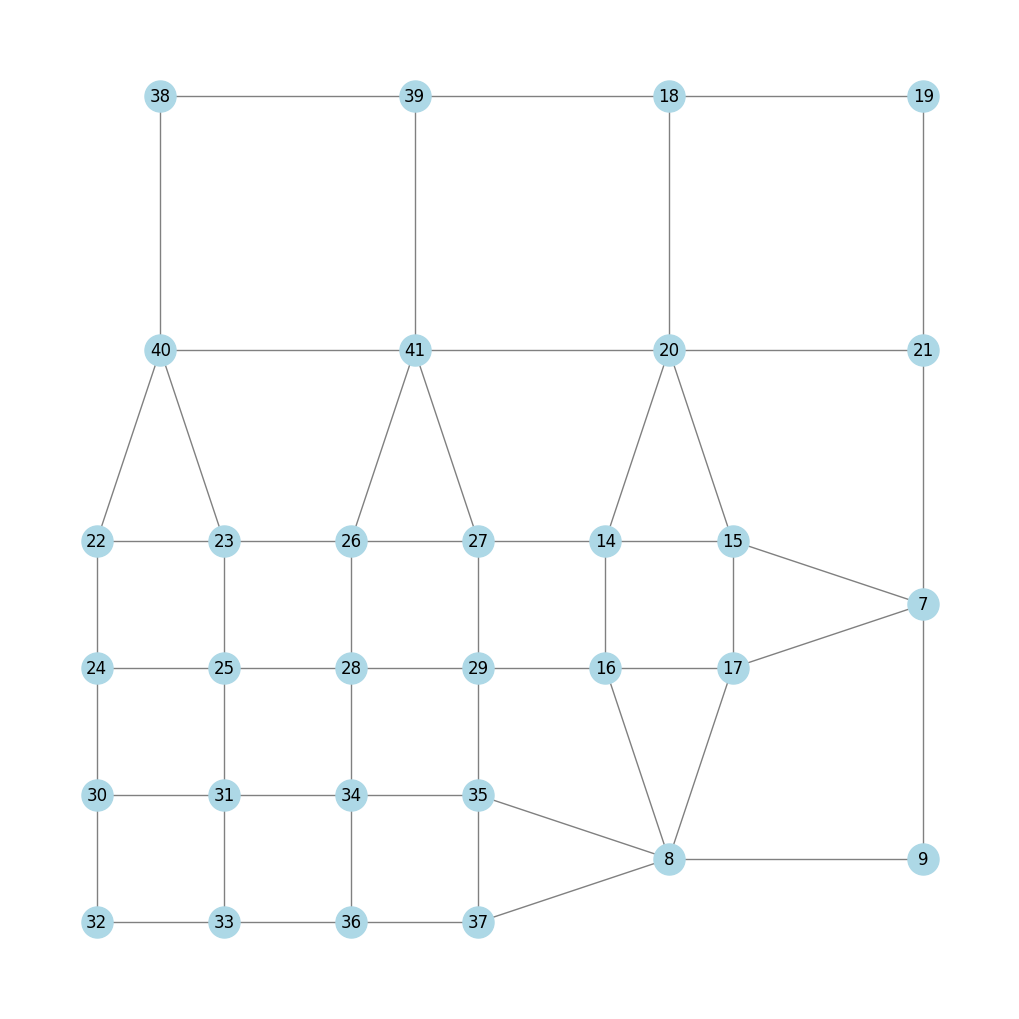

Límite alcanzado
Salas creadas: 3


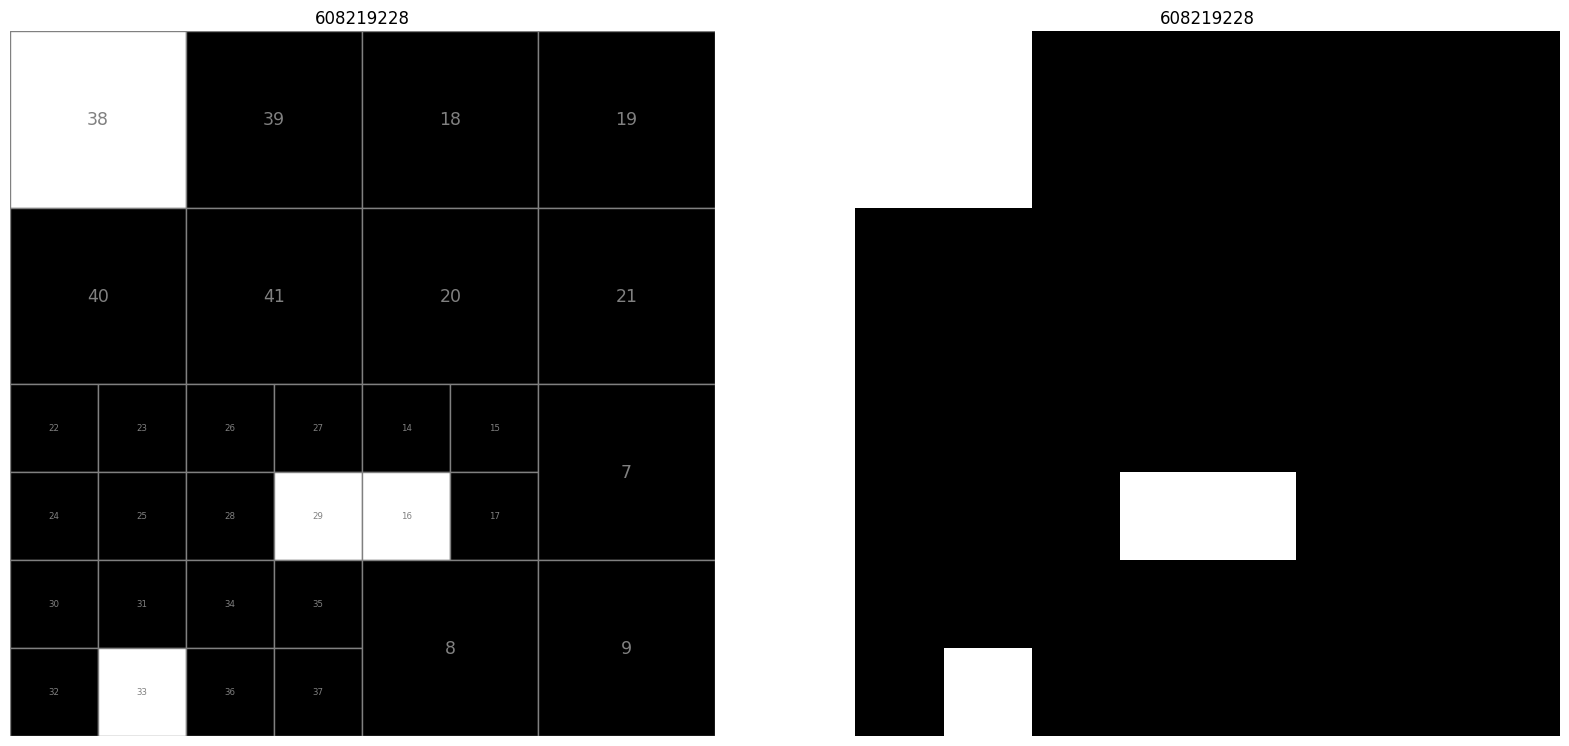

In [231]:
# 'dikjstra', 'clasica'
arquitectura = 'clasica'
npart = 10
prof = 3
nsalas = 5
densidad = 1
guardar = False

cuadrado=crear_mazmorra_space_part(
    arquitectura = arquitectura,
    npart=npart,
    prof_division=prof,
    nsalas=nsalas,
    densidad=densidad,
    guardar=guardar
)

In [232]:
def fill_matrix_from_quadtree(cuadrado, matrix, tamaño):
    """Rellena la matriz con valores desde un quadtree."""
    if cuadrado is None:
        return
    lado = 2 ** cuadrado.profundidad
    step = lado / tamaño

    if not cuadrado.cuadrantes:  # Es una hoja
        #print(f"Nodo: {cuadrado.nodo}")
        value = 0 if cuadrado.tipo == 'pared' else 1
        #print(f"Valor: {value}")
        #print(f"{lado}/{tamaño}={step}")
        #print(f"Limites X: {cuadrado.limites[3]} - {cuadrado.limites[1]}")
        #print(f"Limites Y: {cuadrado.limites[2]} - {cuadrado.limites[0]}")

        # Convertir coordenadas del cuadrado a índices de la matriz
        x_start, x_end = int(cuadrado.limites[3] * step), int(cuadrado.limites[1] * step)

        # Corregir inversión del eje Y
        y_start, y_end = lado - int(cuadrado.limites[0] * step), lado - int(cuadrado.limites[2] * step)

        x_start, x_end = max(0, x_start), min(lado, x_end)
        y_start, y_end = max(0, y_start), min(lado, y_end)
        #print(f"Rango X: {x_start} - {x_end}")
        #print(f"Rango Y: {y_start} - {y_end}")
        matrix[y_start:y_end, x_start:x_end] = value
        #print("")
    else:  # Llamar recursivamente a los hijos
        for child in cuadrado.cuadrantes:
            fill_matrix_from_quadtree(child, matrix, tamaño)


In [233]:
def fill_graph_from_quadtree(cuadrado, graph, tamaño):
    """Rellena el grafo con valores desde un quadtree, invirtiendo el eje Y."""
    if cuadrado is None:
        return
    lado = 2 ** cuadrado.profundidad
    step = lado / tamaño

    if not cuadrado.cuadrantes:  # Es una hoja
        value = 0 if cuadrado.tipo == 'pared' else 1

        # Convertir coordenadas del cuadrado a índices del grafo
        x_start, x_end = int(cuadrado.limites[3] * step), int(cuadrado.limites[1] * step)

        # Invertir el eje Y completamente
        y_start, y_end = int(cuadrado.limites[2] * step), int(cuadrado.limites[0] * step)

        # Asegurar que las coordenadas sean válidas dentro de los límites
        x_start, x_end = max(0, x_start), min(lado, x_end)
        y_start, y_end = max(0, y_start), min(lado, y_end)

        # Crear nodos en el grafo para la celda
        for y in range(y_start, y_end):
            for x in range(x_start, x_end):
                graph.add_node((x, y), nodo=cuadrado.nodo, value=value)

        # Conectar los nodos adyacentes si es necesario
        for y in range(y_start, y_end):
            for x in range(x_start, x_end):
                if x < lado - 1:  # Conectar con el nodo a la derecha
                    graph.add_edge((x, y), (x + 1, y))
                if y > 0:  # Conectar con el nodo abajo (invertido), asegurando que no sea la fila superior
                    graph.add_edge((x, y), (x, y - 1))  # Invertir la dirección vertical
                if y < lado - 1:  # Asegurar que no se pase del límite inferior
                    graph.add_edge((x, y), (x, y + 1))  # Conectar con el nodo de arriba (invertido)

    else:  # Llamar recursivamente a los hijos
        for child in cuadrado.cuadrantes:
            fill_graph_from_quadtree(child, graph, tamaño)


In [234]:
graph = nx.Graph()
fill_graph_from_quadtree(cuadrado, graph, cuadrado.tamaño)

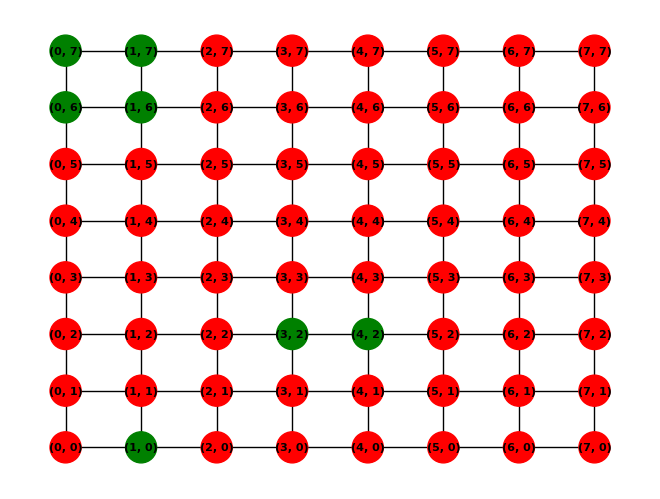

In [235]:
mostrar_grafo(graph)

In [236]:
def dividir(cuadrante=1):
    """Divide el cuadrado en cuatro subcuadrantes exactamente una vez."""
    if cuadrante.cuadrantes:  # Si ya está dividido, no hacer nada
        return
    
    mitad_tamaño = cuadrante.tamaño / 2
    centro_cuadrante = mitad_tamaño / 2
    offsets = [
        (-centro_cuadrante, centro_cuadrante),  # Arriba izquierda
        (centro_cuadrante, centro_cuadrante),   # Arriba derecha
        (-centro_cuadrante, -centro_cuadrante), # Abajo izquierda
        (centro_cuadrante, -centro_cuadrante)   # Abajo derecha
    ]
    
    for i, offset in enumerate(offsets, start=1):
        nuevo_centro = (cuadrante.centro[0] + offset[0], cuadrante.centro[1] + offset[1])
        nuevo_nodo = f"{cuadrante.nodo}.{i}"  # Crea un identificador único para cada subcuadrante
        cuadrante.G.add_node(nuevo_nodo, profundidad=cuadrante.profundidad+1)
        cuadrante.G.add_edge(cuadrante.nodo, nuevo_nodo)
            
        cuadrante.cuadrantes.append(Cuadrado(cuadrante.G, nuevo_nodo, nuevo_centro, mitad_tamaño))


In [237]:
cuadrante = cuadrado.encontrar_cuadrante()
dividir(cuadrante)
cuadrado.formar_grafo()

TypeError: encontrar_cuadrante() missing 1 required positional argument: 'id'

In [ ]:
#cuadrado.dibujar()
#cuadrado.dibujar_grafo()
#cuadrado.salas

In [ ]:
import copy

clon = copy.deepcopy(cuadrado)


In [ ]:
S = clon.S
G = clon.G
aristas = S.edges
for edge in aristas:
    primero = clon.encontrar_cuadrante(edge[0]).tipo
    segundo = clon.encontrar_cuadrante(edge[1]).tipo
    if primero == 'suelo':
        if segundo == 'suelo': # (suelo, suelo)
            aristas[edge]['peso'] = 10
        else: # (suelo, pared)
            aristas[edge]['peso'] = 10
    else:
        if segundo == 'suelo': # (pared,suelo)
            aristas[edge]['peso'] = 10
        else: # (pared, pared)
            aristas[edge]['peso'] = 0
    #print(f"Arista {edge}")
    '''if not clon.comprobar_adyacentes(edge[1]):
        aristas[edge]['peso'] = 5'''
        #print("\n\n")

In [ ]:
clon.dibujar_grafo()

In [ ]:
source = 26
target = 21

camino = nx.shortest_path(S, source=source, target=target, weight = 'peso')[1:-1]
print(camino)

In [ ]:
selec = camino[0]
tamaño = G.nodes[selec]['profundidad']
print(f"Nodo: {selec}; Tamaño: {tamaño}")
cuadrante = clon.encontrar_cuadrante(selec)

if tamaño <= clon.profundidad:
    print("\tSe puede dividir más.")
    dividir(cuadrante)
    clon.formar_grafo()
camino.remove(selec)
print(camino)